In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('..DataSets/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
#importing modules
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re

In [11]:
dataset = pd.read_csv('DataSets/BERT based sentiment detection/tweet_emotions.csv')

In [12]:
dataset.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [13]:
dataset.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


<AxesSubplot:xlabel='sentiment'>

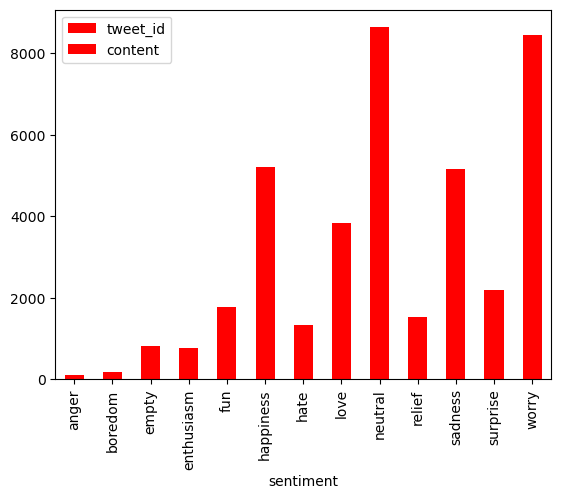

In [14]:
dataset.groupby('sentiment').count().plot.bar(color='red')

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='content', ylabel='Density'>

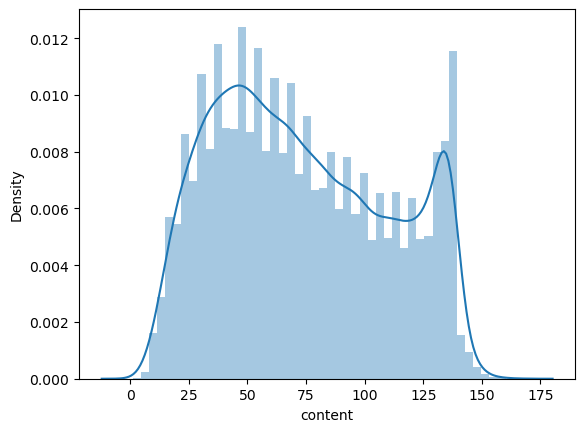

In [15]:
#plotting the distibution of number of characters in the tweets
sns.distplot(dataset.content.str.len())

In [16]:
#dropping unneccessary columns
dataset = dataset.drop(['tweet_id'],axis=1)
dataset.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [17]:
labels, features = [],[]
labels = pd.get_dummies(dataset['sentiment']).values
dataset =dataset.drop(['sentiment'], axis=1)
#converting to numerical
#converting content column in train and val set to text so as to convert any floating point/int content to str
features = dataset.content.astype(str).values

In [18]:
# creating train and val_splits
X_train,X_val,y_train,y_val = train_test_split(features,labels, test_size=0.25)

In [19]:
print("Input training features and label shape are {},{}".format(X_train.shape,y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,y_val.shape))

Input training features and label shape are (30000,),(30000, 13)
Input validation features and label shape are (10000,), (10000, 13)


In [20]:
!pip install -q tensorflow-text

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Anaconda\\Lib\\site-packages\\google\\~upb\\_message.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [21]:
!pip install -q tf-models-official

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [16 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\coco.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\cocoeval.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\mask.py -> build\lib.win-amd64-cpython-39\pycocotools
  copying pycocotools\__init__.py -> build\lib.win-amd64-cpython-39\pycocotools
  running build_ext
  cythoning pycocotools/_mask.pyx to pycocotools\_mask.c
  C:\Users\maxim\AppData\Local\Temp\pip-build-env-qzz7oybl\overlay\Lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\maxim\AppData\Local\Temp\pip-install-78widcdm\pycocotools_2f25321e577f470696bde76a6bcadeb6\pycocotools\_mask.pyx

In [ ]:
# to create AdamW optimizer
from official.nlp import optimization
import tensorflow_hub as hub
import tensorflow_text as text

In [22]:
bert_model_name_encoder = 'bert_en_uncased_L-12_H-768_A-12'
encoder_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_model_name_preprocess = 'bert_en_uncased_L-12_H-768_A-12'
preprocess_download_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [23]:
print(f'BERT model selected           : {encoder_download_link}')
print(f'Preprocess model auto-selected: {preprocess_download_link}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [24]:
#loading bert_preprocessor and bert encoder
bert_preprocessor = hub.KerasLayer(preprocess_download_link, name='preprocessing')
bert_encoder = hub.KerasLayer(encoder_download_link, name='BERT_encoder')

NameError: name 'hub' is not defined

In [ ]:
#defining the model with few tweaks to original
def classifier_model():
    text_input = Input(shape =(), dtype= tf.string, name='text')
    #preprocesing layer
    preprocessed_text = bert_preprocessor(text_input)
    #passing through encoder layer
    embeddings = bert_encoder(preprocessed_text)
    #fetching the pooled_output from the dictionary of outputs
    output = embeddings['pooled_output']
    output = Dropout(0.2)(output)
    #passing through final dense layer with softmax
    output = Dense(13, activation=None, name='classifier_end')(output)
    return Model(text_input, output)
classifier = classifier_model()

In [ ]:
classifier.summary()

In [ ]:
#defining the loss function
loss = CategoricalCrossentropy(from_logits=True)
metrics = CategoricalAccuracy()

In [ ]:
steps_per_epoch =len(X_train)
num_train_steps = steps_per_epoch * 10
num_warmup_steps = int(0.01*num_train_steps)

init_lr = 1e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
#compiling the model
classifier.compile(optimizer = optimizer, loss=loss, metrics=metrics)

In [ ]:
#fitting the model
history = classifier.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=1)

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#saving model
classifier.save('Models/trained_BERT_Classifier.h5')

In [ ]:
test_string1 = ["I am afraid that I won't be available on call tommorow!"]
test_string2 = ["This is an awesome course, I loved it"]
def predict(test_string):
    class_prob = classifier.predict(test_string, batch_size=1)[0]
    if np.argmax(class_prob)==0:
        print("Negative Sentiment")
    elif np.argmax(class_prob)==1:
        print("Neutral Sentiment")
    else:
        print("Positive Sentiment")

In [ ]:
predict(test_string1)
predict(test_string2)